In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import altair
import vega_datasets
import sklearn
import bokeh
import datashader
import holoviews
import wordcloud
import spacy
import datetime

C:\Users\kdebr\Anaconda3\envs\dviz\lib\site-packages\distributed\utils.py:138: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [WinError 10051] A socket operation was attempted to an unreachable network
  RuntimeWarning,


### Import data

In [2]:
# Food expenditures data from ERS (Economic Research Service, USDA)
#########foodexp = pd.read_csv('faps_fahitem_puf.csv')
#########with open(, 'rb') as f:
    ###########contents = f.read()
# NOTE - I need to find the documentation for this, not sure what dates I am looking at?

#### Monthly expenditures data (ERS)

In [3]:
# Monthly expenditures data, ERS (USDA) Updated Feb 25, 2020
# How much people spent on food; should mirror the census information. Might be extraneous/unnecessary
#Note, 'constant dollar' refers to 1988 = 100
monthly_sales=pd.read_csv('../data/monthly_sales_cleaned.csv')
monthly_sales.head()

,Year,Month,FAH_nominal_wtax_wtips_million,FAFH_nominal_wtax_wtips_million,Total_nominal_food_sales_million,FAH_constdollar_million,FAFH_constdollar_million,Total_constant_dollar_food_sales_million
0,2019.0,December,"74,901.67","73,337.91","148,239.58","36,125.06","31,012.62","67,423.64"
1,2019.0,November,"69,798.19","69,585.45","139,383.64","33,666.99","29,510.12","63,482.68"
2,2019.0,October,"67,301.77","71,609.53","138,911.30","32,380.60","30,417.63","63,227.35"
3,2019.0,September,"64,101.42","69,391.72","133,493.14","30,942.60","29,531.69","60,922.88"
4,2019.0,August,"69,333.52","75,675.25","145,008.77","33,522.32","32,289.19","66,314.81"


#### Census data

In [60]:
# Census data
# https://www.census.gov/econ/currentdata/dbsearch?program=MARTS&startYear=1992&endYear=2020&categories%5B%5D=445&categories%5B%5D=4451&categories%5B%5D=446&categories%5B%5D=722&dataType=SM&geoLevel=US&adjusted=1&notAdjusted=1&submit=GET+DATA&releaseScheduleId=
census = pd.read_csv('../data/census_data_food_only.csv')
census_dates= pd.read_csv('../data/census_per_index_dates.csv')

#### COVID-19 data

In [5]:
# COVID-19 data: (COLLECTED 9:37pm on 5/2/2020)
# https://docs.google.com/spreadsheets/u/2/d/e/2PACX-1vRwAqp96T9sYYq2-i7Tj0pvTf6XVHjDSMIKBdZHXiCGGdNC0ypEU9NbngS8mxea55JuCFuua1MUeOj5/pubhtml#
covid = pd.read_csv('../data/COVID19_cases_may20_2020.csv')
covid.head()

,Date_int,Date,States,Positive,Negative,Pending,Hospitalized_Currently,Hospitalized_Cumulative,In_ICU_Currently,In_ICU_Cumulative,On Ventilator_Currently,On Ventilator_Cumulative,Recovered,Deaths
0,20200520,5/20/2020,56,1542309,11105482.0,2973.0,40884.0,161616.0,9829.0,7319.0,4911.0,613.0,294312.0,87472.0
1,20200519,5/19/2020,56,1520778,10713209.0,2944.0,41174.0,159634.0,9829.0,7217.0,5032.0,606.0,289392.0,86070.0
2,20200518,5/18/2020,56,1499722,10334786.0,3596.0,40933.0,157963.0,10015.0,7064.0,5257.0,602.0,283178.0,84640.0
3,20200517,5/17/2020,56,1480158,10016330.0,3449.0,41108.0,156905.0,10164.0,7003.0,5467.0,593.0,272265.0,83854.0
4,20200516,5/16/2020,56,1459421,9633108.0,3788.0,42896.0,155726.0,10509.0,6945.0,5529.0,592.0,268376.0,83015.0


#### Vegetables data

In [6]:
# Vegetables_pulses data: from USDA/ERS
vegetables = pd.read_csv('../data/Vegetables_Pulses/Vegetables_Pulses.csv')
vegetables.head()

,Decade,Year,Commodity,EndUse,Category,Item,Unit,PublishValue
0,1970's,1970,Artichokes,All uses,Supply,Production,Million pounds,67.10
1,1970's,1970,Artichokes,All uses,Supply,Imports,Million pounds,28.50
2,1970's,1970,Artichokes,All uses,Supply,Total Supply,Million pounds,95.60
3,1970's,1970,Artichokes,All uses,Availability,Domestic Availability,Million pounds,95.60
4,1970's,1970,Artichokes,All uses,Availability,Per Capita Availability,Pounds,0.47


### EDA: census data


This data gives "Advance monthly sales for retail and food services", one data point per month for all years between Jan 1992 and April 2020. 

- per_idx is the period index or date at which the data was collected. These correspond to actual date values.
- dt_idx describes the data type: 1 = Monthly sales in millions of US dollars. 2 = Monthly sales % change.
- et_idx describes error types: 1 = CV of sales, monthly. 2 = SE of sales, monthly % change.
- is_adj refers to whether or not the data was (1) or was not (0) seasonally adjusted.
- val = monthly sales value in millions of US dollars from (in this case) grocery stores.

All data was taken over the entire US as a whole.
Data source: US Census

In [61]:
census.head()

,per_idx,cat_idx,dt_idx,et_idx,geo_idx,is_adj,val,cat_name
0,1,11,1,0,1,0,29589.0,food_bev_stores
1,1,11,1,0,1,1,30437.0,food_bev_stores
2,1,12,1,0,1,0,27306.0,grocery_stores
3,1,12,1,0,1,1,27835.0,grocery_stores
4,1,21,1,0,1,0,15693.0,food_drink_service


In [62]:
census.shape

(6822, 8)

In [63]:
census.describe()

,per_idx,cat_idx,dt_idx,et_idx,geo_idx,is_adj,val
count,6822.000000,6822.000000,6822.000000,6822.000000,6822.0,6822.000000,6822.000000
mean,193.005277,14.666667,0.895339,0.604222,1.0,0.500000,12037.574905
std,90.729429,4.497242,0.830731,0.801278,0.0,0.500037,19559.247815
min,1.000000,11.000000,0.000000,0.000000,1.0,0.000000,-31.700000
25%,127.000000,11.000000,0.000000,0.000000,1.0,0.000000,0.200000
50%,198.000000,12.000000,1.000000,0.000000,1.0,0.500000,1.200000
75%,269.000000,21.000000,2.000000,1.000000,1.0,1.000000,29074.750000
max,340.000000,21.000000,2.000000,2.000000,1.0,1.000000,80774.000000


#### Joining correct per_name column

In [64]:
census = census.merge(census_dates, how = 'left', on = 'per_idx')
census['per_name']=pd.to_datetime(census['per_name'], format='%m/%d/%Y')
census.head()


,per_idx,cat_idx,dt_idx,et_idx,geo_idx,is_adj,val,cat_name,per_name
0,1,11,1,0,1,0,29589.0,food_bev_stores,1992-01-01
1,1,11,1,0,1,1,30437.0,food_bev_stores,1992-01-01
2,1,12,1,0,1,0,27306.0,grocery_stores,1992-01-01
3,1,12,1,0,1,1,27835.0,grocery_stores,1992-01-01
4,1,21,1,0,1,0,15693.0,food_drink_service,1992-01-01


#### Filtering data

In [65]:
# Only dollar data, separated by adjusted/unadjusted
census_unadj = census[(census['is_adj'] < 1) & (census['dt_idx'] == 1)] # this is $ data
census_adj = census[(census['is_adj'] == 1) & (census['dt_idx'] == 1)] # this is $ data

# Only percentage data, separated by adjusted/unadjusted
census_unadj_pct = census[(census['is_adj'] < 1) & (census['dt_idx'] == 2)] # this is % data
census_adj_pct = census[(census['is_adj'] == 1) & (census['dt_idx'] == 2)] # this is % data



#### Line plots: Census data, 1992-2020


[Text(0, 0.5, 'Total Sales, Million $'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Total US Adjusted Grocery and Foodservice Sales')]

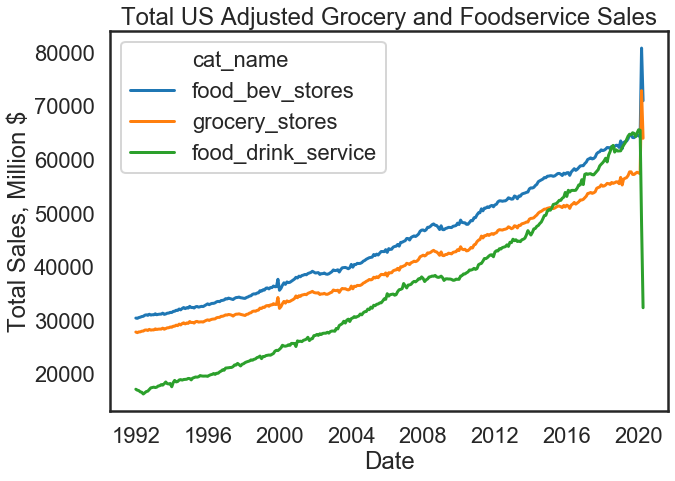

In [83]:
plotsize=(10,7)
sns.set_style("white")
sns.set_context("poster")
fig, ax = plt.subplots(figsize=plotsize)
sns.lineplot(ax=ax, x="per_name", y="val", hue='cat_name',data=census_adj)
#ax2 = plt.twinx()
#sns.lineplot(ax=ax2, x = 'per_name', y = 'val', hue='cat_idx', color= 'b', data= census_unadj)

ax.set(xlabel='Date', ylabel='Total Sales, Million $', title='Total US Adjusted Grocery and Foodservice Sales')
#ax2.set(ylabel = 'Total U.S. Grocery Sales, Million $')
#ax.set(xlim=(datetime.date(2015,1,1), datetime.date(2020,4,1)))
#ax2.set(xlim=(datetime.date(2015,1,1), datetime.date(2020,4,1)))

Nothing even close to this level of disruption has occurred in the food and beverage/food service markets since at least 1992. This is the obvious takeaway from the graph above, but we can also see that in the mid 2010s, gross adjusted total US food/drink service sales overtook that of grocery stores, and continued rising to meet or exceed total sales from all types of food and beverage stores in the late 2010s. In fact, this line seems to have begun accelerating at around the same time (approx 2013 or so). 

This is interesting, as it means we as a country had just begun to pay as much or more for food away-from-home as we did for food at-home, at least until earlier this year. People were going out to restaurants and bars and spending more than they ever were before (especially considering these are adjusted dollars) until the Coronavirus crisis hit. 



#### Linear regression

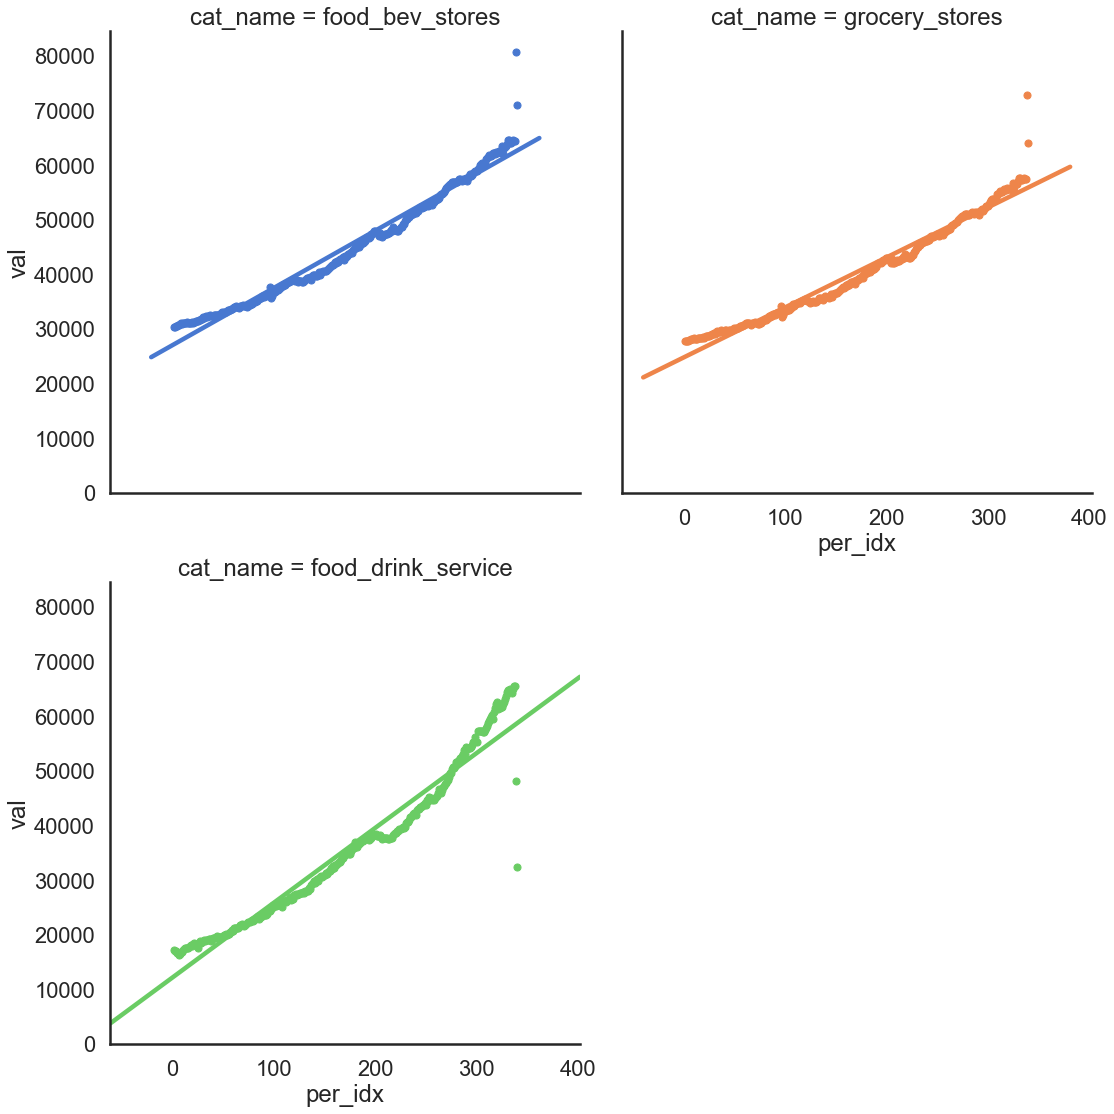

In [105]:
lmplot1=sns.lmplot(x="per_idx", y="val", col="cat_name",hue='cat_name', data=census_adj, 
          col_wrap=2, ci=None, palette="muted", size=8, scatter_kws={"s": 50, "alpha": 1})

Linear regression on the census data (adjusted) shows quite linear behavior with some curvature (concave). The `food_drink_service` shows the most un-linear behavior of the three selected, and seems steeper than the linear regression line would indicate. This could be better represented by a polynomial curve. We can clearly see the outliers from 2020 in all three cases!

Let's extract the information from the lmplots:

In [135]:
for category in census_adj.groupby('cat_name'):
    slope, intercept, r_value = stats.linregress('per_idx', 'val')

TypeError: len() of unsized object

AttributeError: 'str' object has no attribute 'unique'

C:\Users\kdebr\Anaconda3\envs\dviz\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\kdebr\Anaconda3\envs\dviz\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


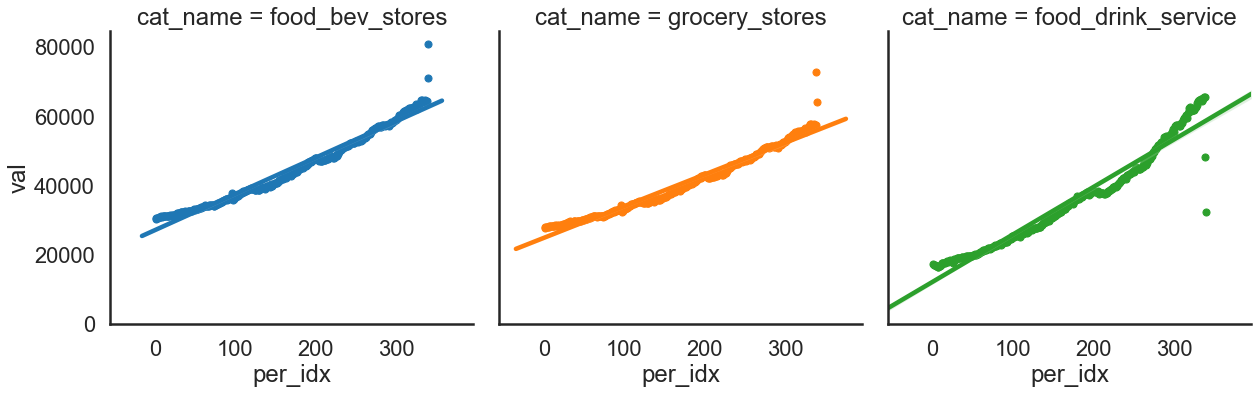

In [131]:
sns.set_context("poster")
g = sns.FacetGrid(census_adj, col="cat_name", hue='cat_name', size=6,  margin_titles=False)
g.map(sns.regplot, "per_idx", "val", fit_reg=True, scatter_kws={"s": 50, "alpha": 1})


In [ ]:

# not going to work yet because data shape is not correct? Hexbin plot idea 
#g = sns.jointplot(census_adj['blebleble'], movies['Rotten_Tomatoes_Rating'], s=5, alpha=0.2, facecolors='none', edgecolors='b')

In [ ]:
# TO DO: LINEAR REGRESSION ON THESE  (PRE COVID) TO SEE WHERE WE WOULD HAVE BEEN HAD WE NOT SEEN COVID.
# WAS THERE AN ACCELERATION IN FOOD/DRINK SERVICE? IF SO, WHEN? IS IT LINEAR OR NOT REALLY?
# PROPORTIONALLY IT'S MUCH WORSE FOR FOOD SERVICE THAN IT IS BETTER FOR GROCERY STORES.

#### Line plots: Census data, last 5 years

[(40000, 85000)]

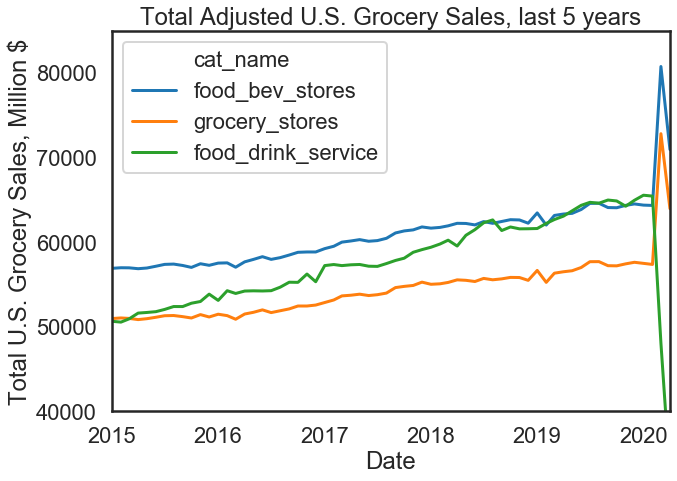

In [67]:
plotsize=(10,7)
sns.set_style("white")
sns.set_context("poster")
fig, ax = plt.subplots(figsize=plotsize)
sns.lineplot(ax=ax, x="per_name", y="val", hue='cat_name',data=census_adj)
#ax2 = plt.twinx()
#sns.lineplot(ax=ax2, x = 'per_name', y = 'val', hue='cat_idx', color= 'b', data= census_unadj)

ax.set(xlabel='Date', ylabel='Total U.S. Grocery Sales, Million $', title='Total Adjusted U.S. Grocery Sales, last 5 years')
#ax2.set(ylabel = 'Total U.S. Grocery Sales, Million $')
ax.set(xlim=(datetime.date(2015,1,1), datetime.date(2020,4,1)))
ax.set(ylim=(40000,85000))
#ax2.set(xlim=(datetime.date(2015,1,1), datetime.date(2020,4,1)))

### Line plots: Percentage data

[Text(0, 0.5, 'Total U.S. Grocery Sales, Million $'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Total Adjusted U.S. Grocery Sales, 1992-2020')]

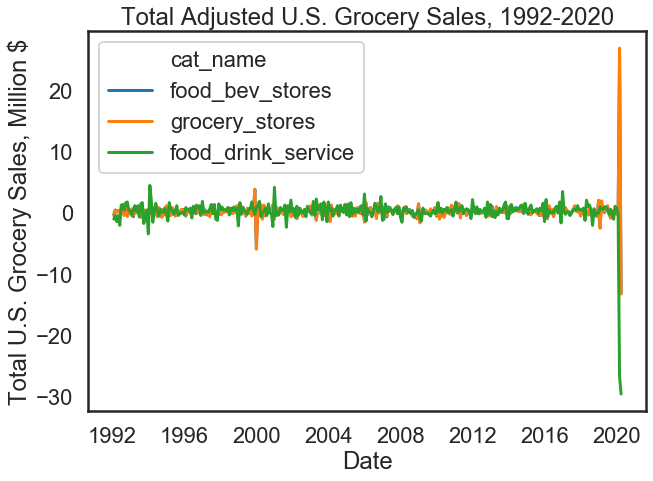

In [68]:
plotsize=(10,7)
sns.set_style("white")
sns.set_context("poster")
fig, ax = plt.subplots(figsize=plotsize)
sns.lineplot(ax=ax, x="per_name", y="val", hue='cat_name',data=census_adj_pct)
#ax2 = plt.twinx()
#sns.lineplot(ax=ax2, x = 'per_name', y = 'val', hue='cat_idx', color= 'b', data= census_unadj)

ax.set(xlabel='Date', ylabel='Total U.S. Grocery Sales, Million $', title='Total Adjusted U.S. Grocery Sales, 1992-2020')
#ax2.set(ylabel = 'Total U.S. Grocery Sales, Million $')
#ax.set(xlim=(datetime.date(2015,1,1), datetime.date(2020,4,1)))
#ax2.set(xlim=(datetime.date(2015,1,1), datetime.date(2020,4,1)))

Apparently the blue line (food_bev_stores) does not exist in percentage data in this dataset; this could be because it's a grouped category made up of other smaller subcategories.

[(735599.0, 737516.0)]

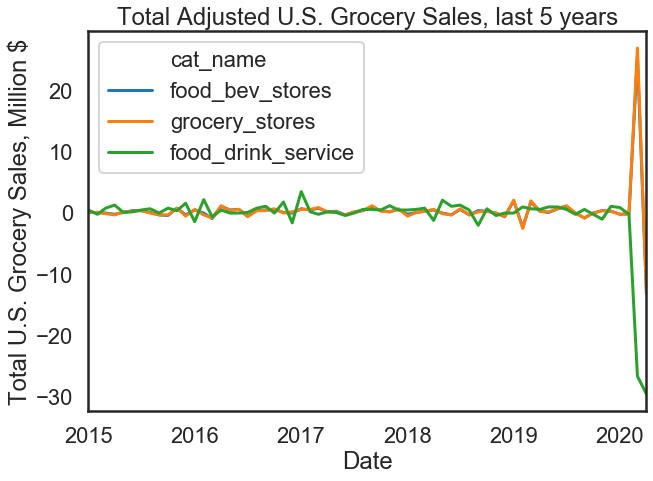

In [69]:
plotsize=(10,7)
sns.set_style("white")
sns.set_context("poster")
fig, ax = plt.subplots(figsize=plotsize)
sns.lineplot(ax=ax, x="per_name", y="val", hue='cat_name',data=census_adj_pct)
#ax2 = plt.twinx()
#sns.lineplot(ax=ax2, x = 'per_name', y = 'val', hue='cat_idx', color= 'b', data= census_unadj)

ax.set(xlabel='Date', ylabel='Total U.S. Grocery Sales, Million $', title='Total Adjusted U.S. Grocery Sales, last 5 years')
#ax2.set(ylabel = 'Total U.S. Grocery Sales, Million $')
ax.set(xlim=(datetime.date(2015,1,1), datetime.date(2020,4,1)))
#ax2.set(xlim=(datetime.date(2015,1,1), datetime.date(2020,4,1)))

[(737060.0, 737546.0)]

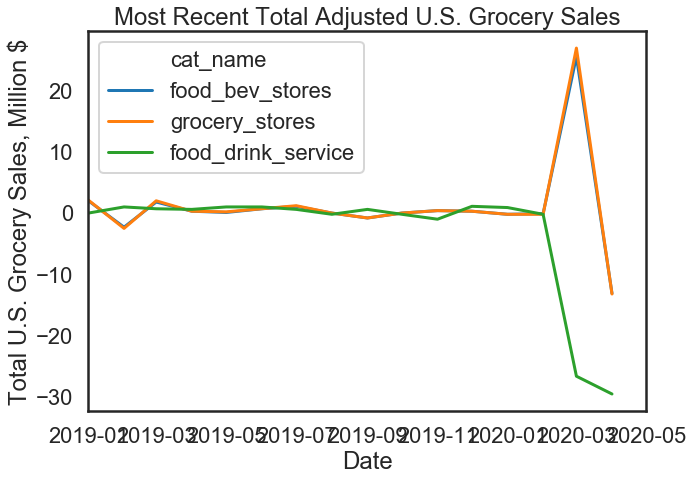

In [72]:
plotsize=(10,7)
sns.set_style("white")
sns.set_context("poster")
fig, ax = plt.subplots(figsize=plotsize)
sns.lineplot(ax=ax, x="per_name", y="val", hue='cat_name',data=census_adj_pct)
#ax2 = plt.twinx()
#sns.lineplot(ax=ax2, x = 'per_name', y = 'val', hue='cat_idx', color= 'b', data= census_unadj)

ax.set(xlabel='Date', ylabel='Total U.S. Grocery Sales, Million $', title='Most Recent Total Adjusted U.S. Grocery Sales')
#ax2.set(ylabel = 'Total U.S. Grocery Sales, Million $')
ax.set(xlim=(datetime.date(2019,1,1), datetime.date(2020,5,1)))
#ax2.set(xlim=(datetime.date(2015,1,1), datetime.date(2020,4,1)))

We can see the striking and intense downward trend of the food and drink service industry sales (green) corresponding exactly and inversely to the uptick in grocery store sales (orange). Unquestionably, this is a direct result of the COVID-19 pandemic stay-at-home orders and shutdowns of restaurants and bars.

### EDA: Covid-19 data

In [70]:
# Fix data types 
covid.dtypes.value_counts()
# Change date column to datetime type
covid['Date'] = pd.to_datetime(covid['Date'])
covid['Date'].dtypes

dtype('<M8[ns]')

[Text(0, 0.5, 'Cumulative positive coronavirus cases, US-wide'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'US COVID cases, cumulative')]

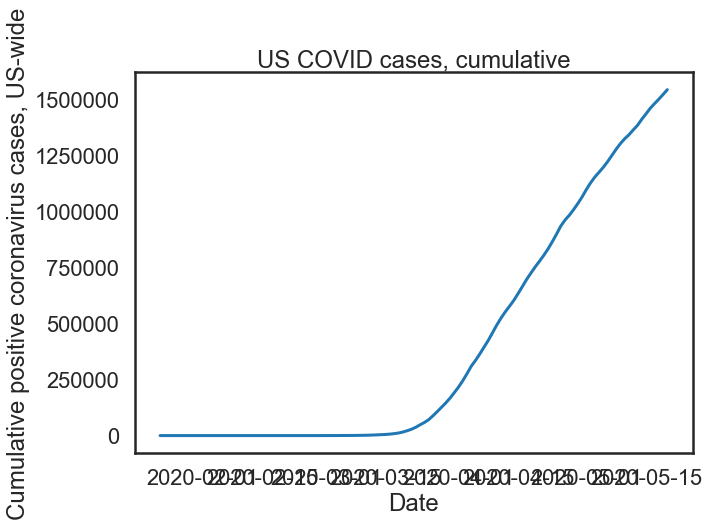

In [17]:
plotsize=(10,7)
sns.set_style("white")
sns.set_context("poster")
fig, ax = plt.subplots(figsize=plotsize)
sns.lineplot(ax=ax, x="Date", y="Positive", data=covid)
#ax2 = plt.twinx()
#sns.lineplot(ax=ax2, x = 'per_name', y = 'val', hue='cat_idx', color= 'b', data= census_unadj)

ax.set(xlabel='Date', ylabel='Cumulative positive coronavirus cases, US-wide', title='US COVID cases, cumulative')
#ax2.set(ylabel = 'Total U.S. Grocery Sales, Million $')
#ax.set(xlim=(datetime.date(2015,1,1), datetime.date(2020,4,1)))
#ax2.set(xlim=(datetime.date(2015,1,1), datetime.date(2020,4,1)))

[Text(0, 0.5, 'Number of people US-wide'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'US COVID cases, deaths, recoveries, cumulative')]

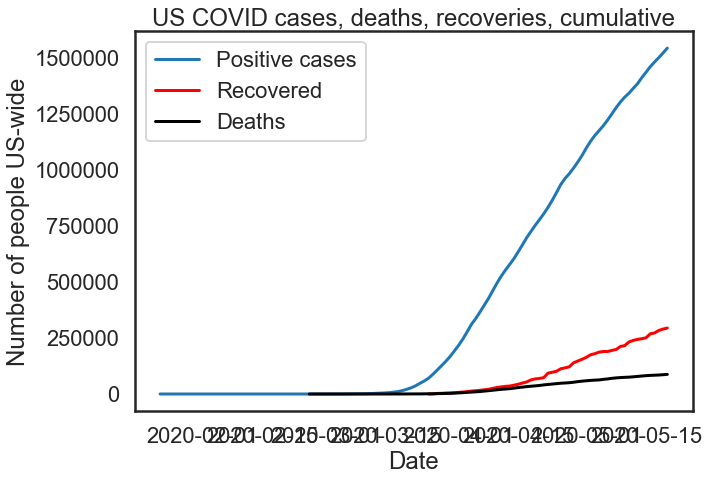

In [18]:
plotsize=(10,7)
sns.set_style("white")
sns.set_context("poster")
fig, ax = plt.subplots(figsize=plotsize)
sns.lineplot(ax=ax, x="Date", y="Positive", label='Positive cases', data=covid)
sns.lineplot(ax=ax, x="Date", y="Recovered", color='red', label='Recovered', data=covid)
sns.lineplot(ax=ax, x="Date", y="Deaths", color='black', label='Deaths', data=covid)
ax.legend()
#ax2 = plt.twinx()
#sns.lineplot(ax=ax2, x = 'per_name', y = 'val', hue='cat_idx', color= 'b', data= census_unadj)

ax.set(xlabel='Date', ylabel='Number of people US-wide', title='US COVID cases, deaths, recoveries, cumulative')

### EDA: monthly_sales

In [19]:
monthly_sales.shape
#There are 281 rows and 8 columns

(281, 8)

In [20]:
#monthly_sales.dtypes.value_counts()
monthly_sales.dropna()

,Year,Month,FAH_nominal_wtax_wtips_million,FAFH_nominal_wtax_wtips_million,Total_nominal_food_sales_million,FAH_constdollar_million,FAFH_constdollar_million,Total_constant_dollar_food_sales_million
0,2019.0,December,"74,901.67","73,337.91","148,239.58","36,125.06","31,012.62","67,423.64"
1,2019.0,November,"69,798.19","69,585.45","139,383.64","33,666.99","29,510.12","63,482.68"
2,2019.0,October,"67,301.77","71,609.53","138,911.30","32,380.60","30,417.63","63,227.35"
3,2019.0,September,"64,101.42","69,391.72","133,493.14","30,942.60","29,531.69","60,922.88"
4,2019.0,August,"69,333.52","75,675.25","145,008.77","33,522.32","32,289.19","66,314.81"
5,2019.0,July,"68,024.06","74,865.75","142,889.81","32,861.14","32,012.86","65,380.20"
6,2019.0,June,"66,585.59","74,299.81","140,885.39","32,159.85","31,835.12","64,515.51"
7,2019.0,May,"69,079.83","75,131.65","144,211.48","33,262.84","32,296.27","66,026.86"
8,2019.0,April,"64,854.45","70,190.13","135,044.58","31,262.73","30,235.69","61,926.26"
9,2019.0,March,"66,186.03","72,894.99","139,081.02","31,815.57","31,502.33","63,773.25"


In [21]:
#Change dtypes from 'object' to float for other columns besides month

numcols=["FAH_nominal_wtax_wtips_million", 
               "FAFH_nominal_wtax_wtips_million", 
               "Total_nominal_food_sales_million", 
               "FAH_constdollar_million", 
               "FAFH_constdollar_million", 
               "Total_constant_dollar_food_sales_million"]

# Remove commas
monthly_sales[numcols] = monthly_sales[numcols].replace({',': ''}, regex=True)

#Convert strings without commas into numeric values
monthly_sales[monthly_sales.columns[2:]] = monthly_sales[monthly_sales.columns[2:]].apply(pd.to_numeric, downcast='float')
monthly_sales.dtypes.value_counts()

float32    6
object     1
float64    1
dtype: int64

In [22]:
monthly_sales.describe()

,Year,FAH_nominal_wtax_wtips_million,FAFH_nominal_wtax_wtips_million,Total_nominal_food_sales_million,FAH_constdollar_million,FAFH_constdollar_million,Total_constant_dollar_food_sales_million
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,2008.000000,48386.148438,43482.070312,91868.218750,27138.095703,24029.515625,51095.445312
std,6.645299,11113.704102,13977.619141,24894.390625,2800.712402,3553.622070,6306.088867
min,1997.000000,28154.230469,21313.570312,49467.800781,20533.080078,16687.750000,37353.718750
25%,2002.000000,38072.917969,31656.329590,69660.880859,25205.272949,21357.254883,46476.108398
50%,2008.000000,48919.115234,42002.826172,90843.816406,27158.325195,23785.455078,50804.230469
75%,2014.000000,57439.553711,53139.175781,111040.453125,28470.807129,26107.371582,55041.477539
max,2019.000000,74901.671875,75675.250000,148239.578125,36125.058594,32296.269531,67423.640625


The data spans 1997 to December 2019. 

FAH = "Food At Home"
FAFH = "Food Away From Home"

Does not includ schools/institutions. Data is in millions of US dollars. Values are total monthly sales.

C:\Users\kdebr\Anaconda3\envs\dviz\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0, 0.5, 'Millions of dollars'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'How much the US spent on food at home and away from home (thru Dec 2019)')]

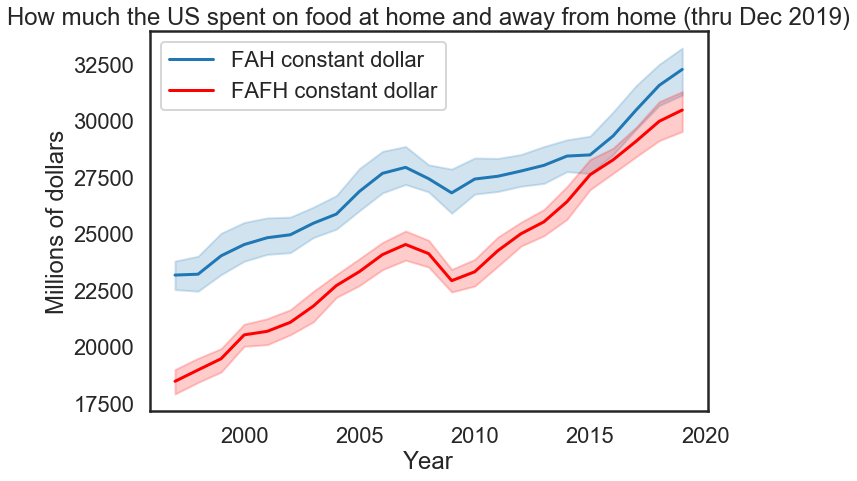

In [23]:
plotsize=(10,7)
sns.set_style("white")
sns.set_context("poster")
fig, ax = plt.subplots(figsize=plotsize)
sns.lineplot(ax=ax, x="Year", y="FAH_constdollar_million", label='FAH constant dollar', data=monthly_sales)
sns.lineplot(ax=ax, x="Year", y="FAFH_constdollar_million", color='red', label='FAFH constant dollar', data=monthly_sales)
#sns.lineplot(ax=ax, x="Year", y="Total_constant_dollar_food_sales_million", color='black', label='Total constant dollar', data=monthly_sales)
ax.legend()
#ax2 = plt.twinx()
#sns.lineplot(ax=ax2, x = 'per_name', y = 'val', hue='cat_idx', color= 'b', data= census_unadj)

ax.set(xlabel='Year', ylabel='Millions of dollars', title='How much the US spent on food at home and away from home (thru Dec 2019)')

Obviously the data above would be way more useful if we had the information from the past few months of 2020.

### EDA: Vegetables data

In [24]:
from dfply import *

veg_stats=(vegetables >> 
           group_by(X.Commodity, X.Year) >> 
           summarize(meanval=X.PublishValue.mean(), medianval=X.PublishValue.median(), stdev=X.PublishValue.std()) )
veg_stats.head()

,Year,Commodity,meanval,medianval,stdev
0,1970,Artichokes,49.298571,47.52,38.612168
1,1971,Artichokes,52.687143,42.68,43.997738
2,1972,Artichokes,59.197143,48.82,46.499236
3,1973,Artichokes,54.762857,57.85,39.751455
4,1974,Artichokes,57.877143,63.33,41.926073


#### Fresh vegetables only, no potatoes


In [25]:
freshveg=(vegetables >> filter_by(X.EndUse=='Fresh'))#, X.Commodity != 'Total vegetables'))
# Remove potatoes as they dwarf all other vegetables. Remove aggregate commodity
freshveg=(freshveg >> filter_by(X.Commodity != 'Potatoes', X.Commodity != 'Total vegetables'))
freshveg.head()

,Decade,Year,Commodity,EndUse,Category,Item,Unit,PublishValue
27,1970's,1970,Asparagus,Fresh,Supply,Production,Million pounds,97.40
28,1970's,1970,Asparagus,Fresh,Supply,Total Supply,Million pounds,97.40
29,1970's,1970,Asparagus,Fresh,Availability,Exports,Million pounds,6.80
30,1970's,1970,Asparagus,Fresh,Availability,Domestic Availability,Million pounds,90.60
31,1970's,1970,Asparagus,Fresh,Availability,Per Capita Availability,Pounds,0.44


##### Fresh vegetables by Item over time

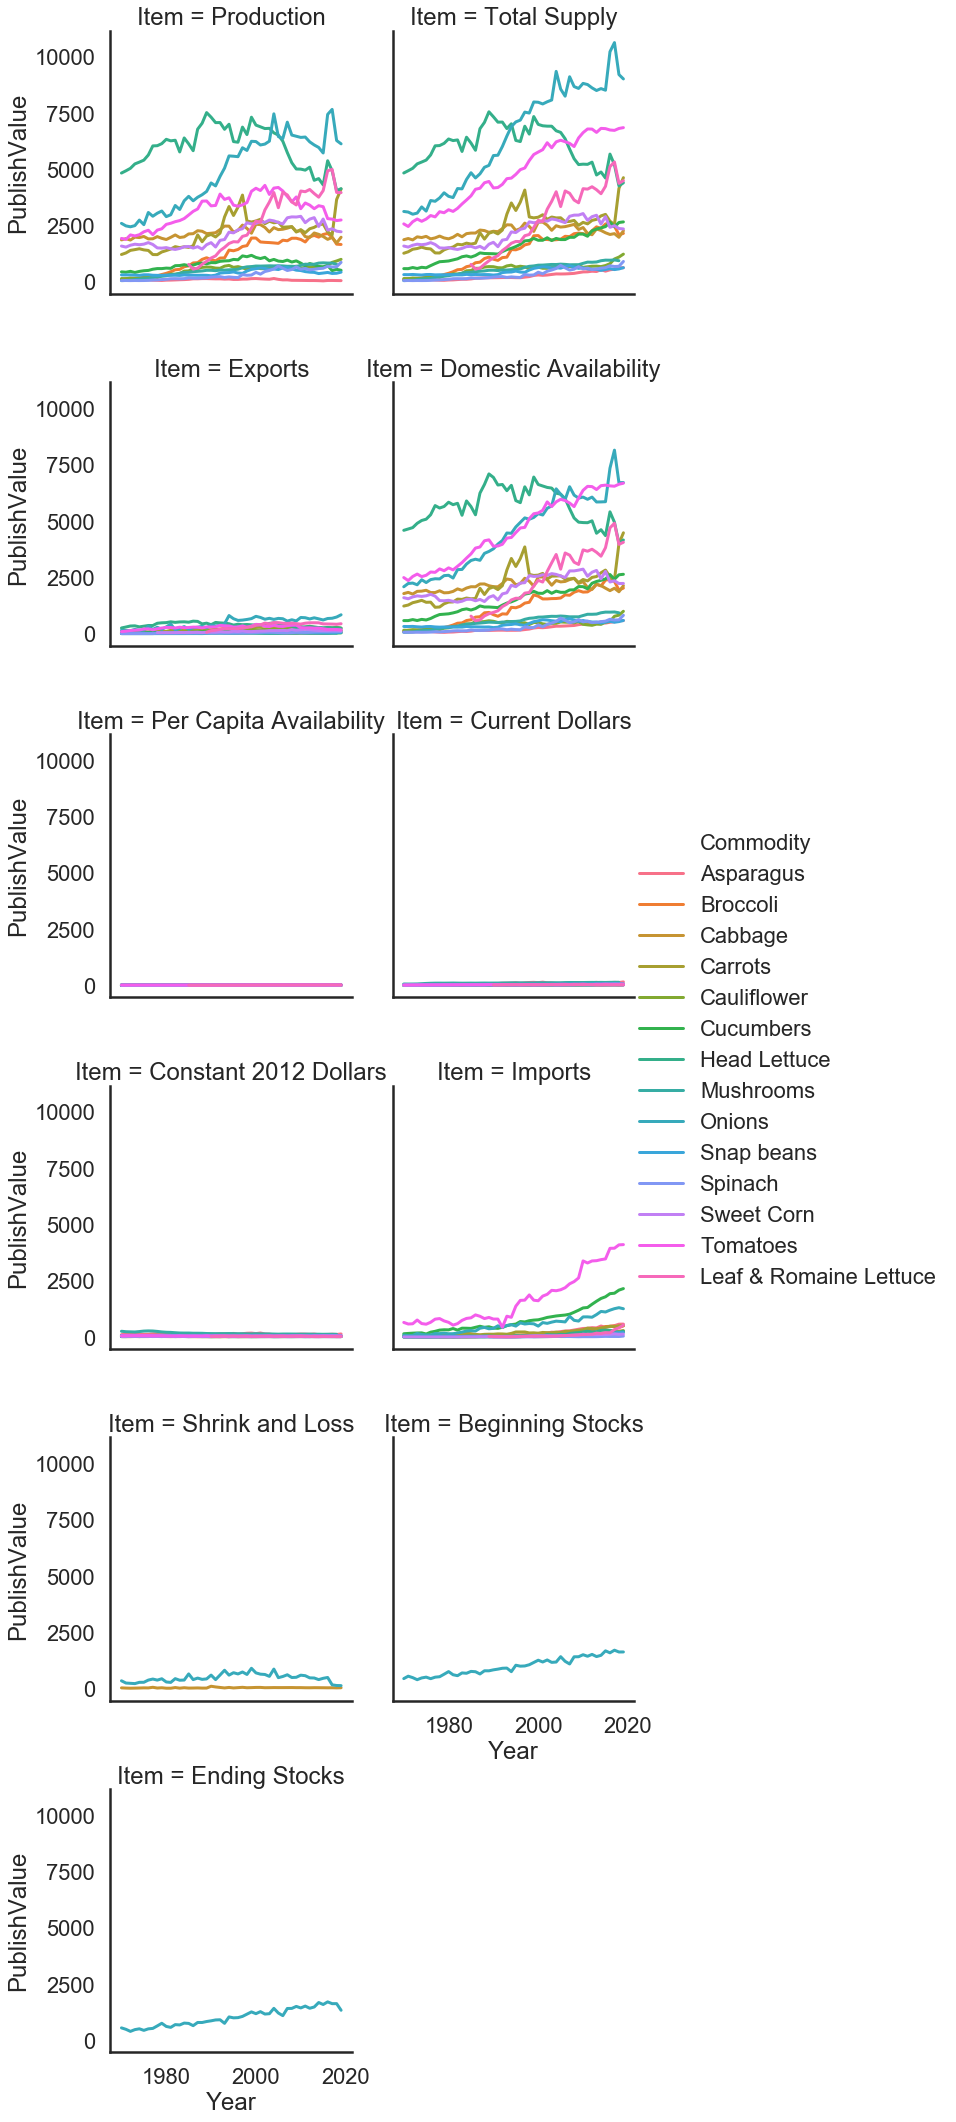

In [26]:
plotsize=(10,7)
sns.set_style("white")
#sns.set_context("poster")
#fig, ax = plt.subplots(figsize=plotsize)

#g=sns.lineplot(x='Year', y='meanval', hue='Commodity',col="Item", col_wrap=2, data=veg_stats)
g=sns.relplot(x="Year", y="PublishValue",
            hue="Commodity", col="Item", col_wrap=2,
            facet_kws=dict(sharex=True),
            kind="line", legend="full", data=freshveg)
#g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

Looks like we should probably filter by Production, and include total supply and domestic availability. Maybe interesting to look at per capita availability

##### Production only

In [27]:
freshveg=(freshveg >> filter_by(X.Item == 'Production'))
freshveg.head()

,Decade,Year,Commodity,EndUse,Category,Item,Unit,PublishValue
27,1970's,1970,Asparagus,Fresh,Supply,Production,Million pounds,97.4
34,1970's,1970,Broccoli,Fresh,Supply,Production,Million pounds,109.2
58,1970's,1970,Cabbage,Fresh,Supply,Production,Million pounds,1866.9
93,1970's,1970,Carrots,Fresh,Supply,Production,Million pounds,1218.2
101,1970's,1970,Cauliflower,Fresh,Supply,Production,Million pounds,151.9


[Text(0, 0.5, 'Million pounds'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'US Fresh vegetable production, 1970-2019')]

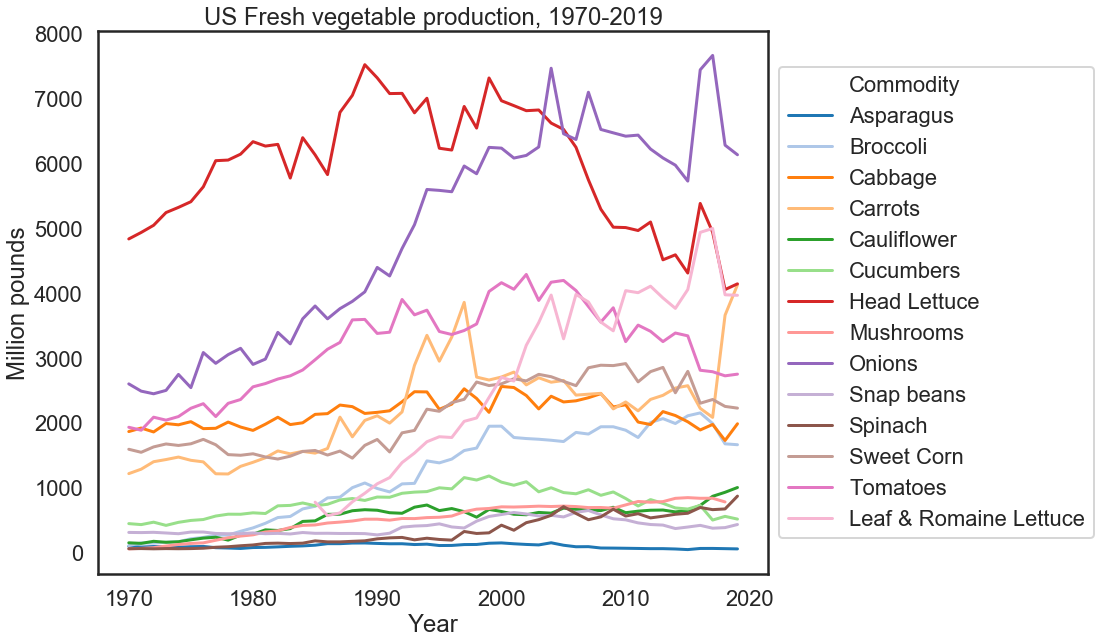

In [28]:
plotsize=(12,10)
sns.set_style("white")
fig, ax = plt.subplots(figsize=plotsize)
from bokeh.palettes import *
palette=sns.color_palette("tab20",14)
sns.set_context("poster")


#g=sns.lineplot(x='Year', y='meanval', hue='Commodity',col="Item", col_wrap=2, data=veg_stats)
g=sns.lineplot(x="Year", y="PublishValue", hue="Commodity",palette=palette, data=freshveg)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

#for line in range(0,freshveg.shape[0]):
#     g.text(freshveg.Year[line]+0.2, freshveg.PublishValue[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
ax.set(xlabel='Year', ylabel='Million pounds', title='US Fresh vegetable production, 1970-2019')



Clearly, head lettuce and onions are produced in the highest quantities overall. Tomatoes, leaf and romaine lettuces, carrots, and sweet corn are the runners-up. These all make sense given the eating habits of the American public and given most of these ingredients' massive popularity as burger toppings! Between the 70s and today, it looks like head lettuce has gone down a lot in popularity, while onions have leveled out and take a strong position as the most-produced in America (by fresh weight). This graph notably does not include culinary fruits or processed, frozen, or other end-uses of vegetables. 

Let's look at one vegetable as an example; carrots:

##### Carrots example

In [29]:
carrots=(vegetables>>(filter_by(X.Commodity=='Carrots', X.Item=='Production')))
carrots.head()



,Decade,Year,Commodity,EndUse,Category,Item,Unit,PublishValue
76,1970's,1970,Carrots,Canning,Supply,Production,Million pounds,405.4
84,1970's,1970,Carrots,Freezing,Supply,Production,Million pounds,315.0
93,1970's,1970,Carrots,Fresh,Supply,Production,Million pounds,1218.2
512,1970's,1971,Carrots,Canning,Supply,Production,Million pounds,458.0
520,1970's,1971,Carrots,Freezing,Supply,Production,Million pounds,261.5


[Text(0, 0.5, 'Million pounds'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'US Carrot production, 1970-2019')]

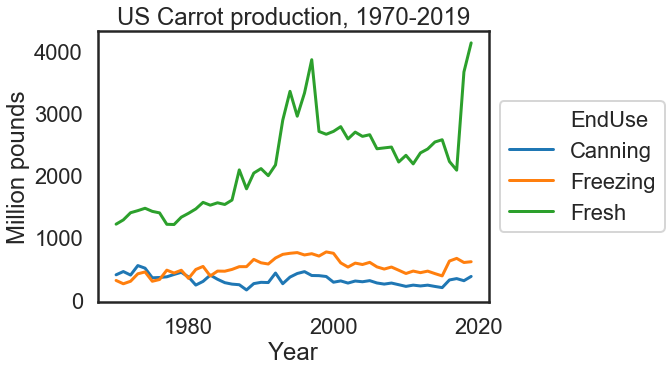

In [36]:
plotsize=(7,5)
sns.set_style("white")
fig, ax = plt.subplots(figsize=plotsize)
#palette=sns.color_palette("tab20",14)
sns.set_context("poster")

#g=sns.lineplot(x='Year', y='meanval', hue='Commodity',col="Item", col_wrap=2, data=veg_stats)
g=sns.lineplot(x="Year", y="PublishValue", hue="EndUse", data=carrots)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
ax.set(xlabel='Year', ylabel='Million pounds', title='US Carrot production, 1970-2019')

Most carrots are produced for fresh produce usage, while fewer are grown for canning or freezing.

##### Eggplant example

[Text(0, 0.5, 'Million pounds'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'US Eggplant production, 1970-2019')]

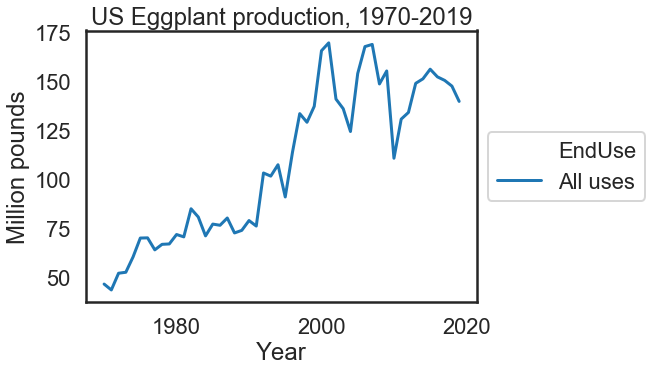

In [47]:
eggplant=(vegetables>>(filter_by(X.Commodity=='Eggplant', X.Item=='Production')))
plotsize=(7,5)
sns.set_style("white")
fig, ax = plt.subplots(figsize=plotsize)
#palette=sns.color_palette("tab20",14)
sns.set_context("poster")

#g=sns.lineplot(x='Year', y='meanval', hue='Commodity',col="Item", col_wrap=2, data=veg_stats)
g=sns.lineplot(x="Year", y="PublishValue", hue="EndUse", data=eggplant)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
ax.set(xlabel='Year', ylabel='Million pounds', title='US Eggplant production, 1970-2019')

Compared to carrots, the y-axis shows that eggplant is far less popular and is produced in amounts several orders of magnitde lower. Its popularity has risen markedly since the 90s, though, as a fresh vegetable, and has approximately tripled since 1970.

##### Tomatoes example

[Text(0, 0.5, 'Million pounds'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'US Tomato production, 1970-2019')]

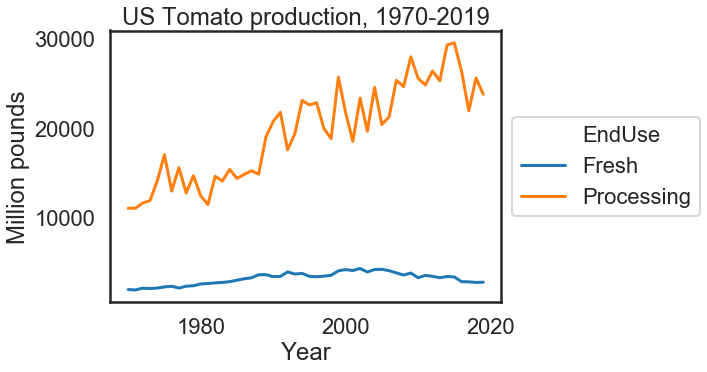

In [51]:
tomatoes=(vegetables>>(filter_by(X.Commodity=='Tomatoes', X.Item=='Production')))
plotsize=(7,5)
sns.set_style("white")
fig, ax = plt.subplots(figsize=plotsize)
#palette=sns.color_palette("tab20",14)
sns.set_context("poster")

#g=sns.lineplot(x='Year', y='meanval', hue='Commodity',col="Item", col_wrap=2, data=veg_stats)
g=sns.lineplot(x="Year", y="PublishValue", hue="EndUse", data=tomatoes)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
ax.set(xlabel='Year', ylabel='Million pounds', title='US Tomato production, 1970-2019')

Unsurprisingly, tomatoes are one of the US's most popular and most-produced fresh vegetables. The majority, however, are grown for processing, while fewer (though still huge amounts) are grown for fresh usage. The prevalence of tomato-based products like soups, sauces, condiments, and flavorings makes this outcome pretty understandable.

#### Total vegetable production

C:\Users\kdebr\Anaconda3\envs\dviz\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


[Text(0, 0.5, 'Million pounds'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Total US vegetable production, 1970-2019')]

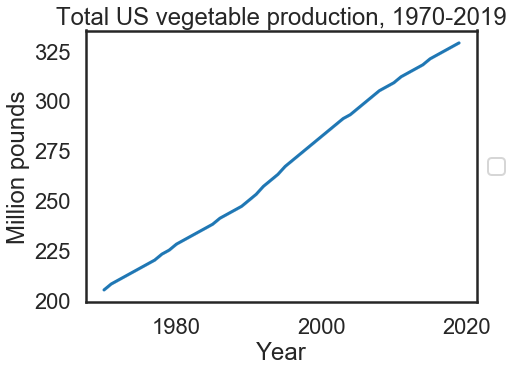

In [59]:
totalveg=(vegetables>>(filter_by(X.Category=='Total')))
plotsize=(7,5)
sns.set_style("white")
fig, ax = plt.subplots(figsize=plotsize)
#palette=sns.color_palette("tab20",14)
sns.set_context("poster")

#g=sns.lineplot(x='Year', y='meanval', hue='Commodity',col="Item", col_wrap=2, data=veg_stats)
g=sns.lineplot(x="Year", y="PublishValue", data=totalveg)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
ax.set(xlabel='Year', ylabel='Million pounds', title='Total US vegetable production, 1970-2019')

Looks like a nearly perfect linear increase in total vegetable production over the last several decades. 

In [81]:
# Total supply minus production (to show how importing habits per veg have changed over time)
# Get the fruit data from ERS
# Check for updated data for Apr/May
# compare total veg against total fruit
# food bank data
# analysis: by how much did food sales go up and by how much did food service go down in a tabular fashion
# what is the month by month anticipated delay/change
# forecasting??
# Correlation of the data with itself/other categories
# use other retail stores and categories to talk about impact of covid

# Meeting discussion notes
##### What should the final product be? What is deliverable - report within this notebook?
##### Discussion of how to incorporate the new data as it comes in (COVID and ERS data both)?
##### What else should I include?
##### Build in the data cleaning steps to this nb so that it's streamlined maybe?
##### How to rotate the x axis labels w/sns (see below)?

### Combining the data with COVID-case data

In [82]:
# TO DO: How to rotate the x axis labels w/sns?

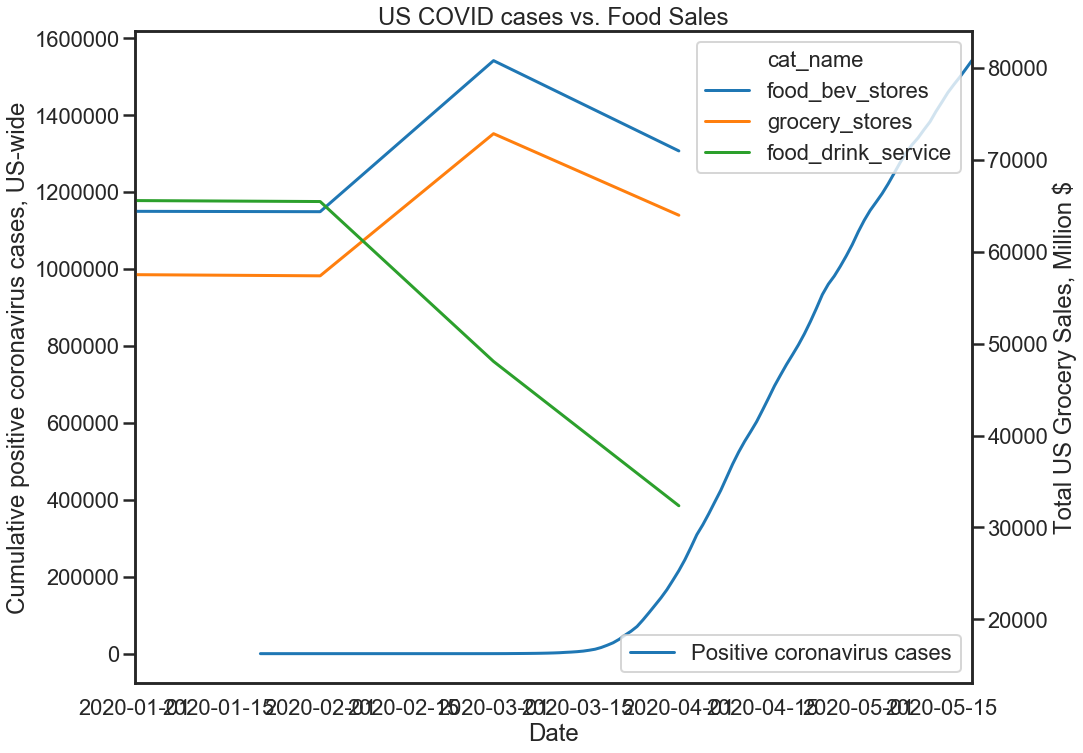

In [80]:
# Combine census (grocery store sales/foodservice sales) data with COVID case data, US-wide

sns.set_context("poster")
plotsize=(15,12)
sns.set_style("white")
fig, ax = plt.subplots(figsize=plotsize)
g=sns.lineplot(ax=ax, x="Date", y="Positive", label='Positive coronavirus cases', data=covid)
ax2 = plt.twinx()
sns.lineplot(ax=ax2, x="per_name", y='val', hue='cat_name', data=census_adj)
ax.set(xlabel='Date', ylabel='Cumulative positive coronavirus cases, US-wide', title='US COVID cases vs. Food Sales')
ax2.set(xlabel='', ylabel='Total US Grocery Sales, Million $')
ax.set(xlim=(datetime.date(2020,1,1), datetime.date(2020,5,20)))
ax2.set(xlim=(datetime.date(2020,1,1), datetime.date(2020,5,20)))
ax.legend(loc='lower right')
ax2.legend()
#g.set_xticklabels(g.get_xticklabels(), rotation=45)

It's clear that we don't have enough data for the most recent time period, but we can clearly see that the change in food sales occurred before the case load became severe in March 2020. After the initial 'stock-up' phase in March, it appears things have begun to retreat to normal for grocery stores and other food/beverage stores in April. However, restaurants are still taking a massive hit, and have not begun to recover at all as of April. As people are slowly returning to their normal eating patterns, they are still not frequenting restaurants (as of April). Because many states began reopening in mid-late May, we could see some beginning of recovery in may or June. 